# SPACEc: Signal Preprocessing

In [2]:
# import spacec first
import spacec as sp

# import standard packages
import os
import numpy as np
import pandas as pd

# silencing warnings
import warnings
warnings.filterwarnings('ignore')

INFO:root: * TissUUmaps version: 3.1.1.6


In [3]:
# Specify the path to the data
root_path = "/home/user/path/SPACEc/" # inset your own path
data_path = root_path + 'example_data/raw/' # where the data is stored

# where you want to store the output
output_dir = root_path + 'example_data/output/'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
#read in segmentation csv files
#Read and concatenate the csv files (outputs from the cell segmentation algorithms). 
df_seg = sp.pp.read_segdf(
    segfile_list = [ # list of segmented files
        output_dir + "tonsil1_mesmer_result.csv", 
        output_dir + "tonsil2_mesmer_result.csv"
    ],
    seg_method = 'mesmer',
    region_list =["reg001", "reg002"],
    meta_list = ["tonsil", "tonsillitis"]
)

#Get the shape of the data
print(df_seg.shape)

#See what it looks like
df_seg.head()

(52454, 71)


,DAPI,FoxP3,HLA-DR,CD103,CHGA,EGFR,CD206,GFAP,PD-1,BCL2,...,eccentricity,perimeter,convex_area,area,axis_major_length,axis_minor_length,label,region_num,unique_region,condition
1,14.681818,0.072727,0.000000,1.490909,1.390909,1.536364,0.118182,0.763636,4.918182,2.109091,...,0.654345,36.970563,115.0,110.0,13.606782,10.289396,1,0,reg001,tonsillitis
2,54.510204,0.173469,3.183673,3.877551,4.918367,2.489796,0.561224,0.918367,10.040816,3.561224,...,0.866483,37.798990,103.0,98.0,15.865016,7.919928,2,0,reg001,tonsillitis
3,54.629630,0.240741,3.462963,4.203704,4.833333,2.407407,0.703704,0.833333,7.611111,3.314815,...,0.615425,26.485281,57.0,54.0,9.663631,7.616834,3,0,reg001,tonsillitis
4,66.348361,0.090164,7.348361,5.512295,5.196721,2.545082,0.602459,0.893443,8.352459,7.946721,...,0.769372,58.870058,259.0,244.0,22.080518,14.105070,4,0,reg001,tonsillitis
5,39.724138,0.068966,1.241379,3.206897,3.413793,2.206897,0.379310,0.724138,6.586207,2.896552,...,0.633516,17.899495,31.0,29.0,6.968100,5.391425,5,0,reg001,tonsillitis


## Filter cells by DAPI intensity and area

In [5]:
# print smallest 1% of cells by area
one_percent_area = np.percentile(df_seg.area, 1)
one_percent_area

36.0

In [6]:
# print smallest 1% of cells by DAPI intensity
one_percent_nuc = np.percentile(df_seg.DAPI, 1)
one_percent_nuc

33.45025166221338

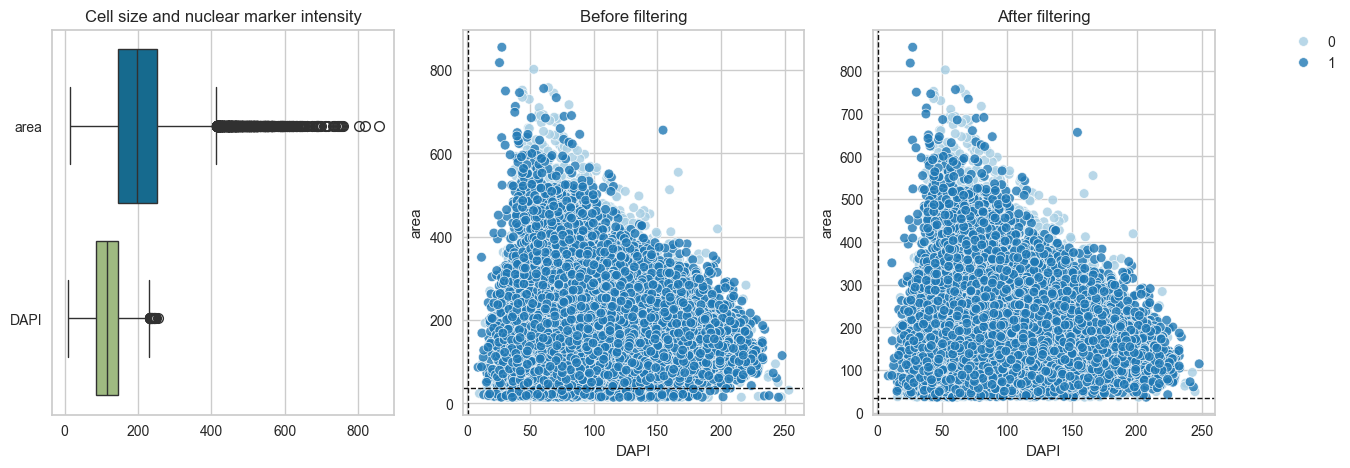

<Figure size 800x550 with 0 Axes>

Percentage of cells kept:  98.99149731193046 %


In [7]:
# If necessary filter the dataframe to remove too small objects or cells without a nucleus. 
# Identify the lowest 1% for cell size and nuclear marker intensity to get a better idea of potential segmentation artifacts.
df_filt = sp.pp.filter_data(
    df_seg, 
    nuc_thres=one_percent_nuc, # remove cells with DAPI intensity below threshold
    size_thres=one_percent_area, # remove cells with area below threshold
    nuc_marker="DAPI", # name of nuclear marker
    cell_size = "area", # name of cell size column
    region_column = "region_num", # column with region numbers
    color_by = "region_num", # color by region number
    log_scale=False) # log scale for size

## Normalize data

In [8]:
# Normalize data with one of the four available methods (zscore as default)
df_filt.columns

Index(['DAPI', 'FoxP3', 'HLA-DR', 'CD103', 'CHGA', 'EGFR', 'CD206', 'GFAP',
       'PD-1', 'BCL2', 'panCK', 'CD45RO', 'CD11b', 'CD56', 'CD163', 'CD21',
       'CD8', 'S100', 'Vimentin', 'PDGFRb', 'CCR7', 'CD57', 'CD34',
       'Synaptophysin', 'CD31', 'CXCR5', 'CD3', 'CD38', 'LAG3', 'CD25', 'CD16',
       'IL-10', 'Ki67', 'CLEC9A', 'p53', 'CD69', 'CD11c', 'CD68', 'Ox40',
       'aSMA', 'CD20', 'CD4', 'MUC-1', 'Podoplanin', 'CD45RA', 'CD15',
       'betaCatenin', 'PAX5', 'MCT', 'FAP', 'CD138', 'Tbet', 'GranzymeB',
       'IDO-1', 'CD45', 'CollagenIV', 'PD-L1', 'Arginase-1', 'GATA3', 'y', 'x',
       'eccentricity', 'perimeter', 'convex_area', 'area', 'axis_major_length',
       'axis_minor_length', 'label', 'region_num', 'unique_region',
       'condition'],
      dtype='object')

In [10]:
# This is to normalize the data per region/tif
dfz = pd.DataFrame()

for region in df_filt.unique_region.unique():
    df_reg = df_filt[df_filt.unique_region == region]
    df_reg_norm = sp.pp.format(
        data=df_reg, 
        list_out= ['eccentricity', 'perimeter', 'convex_area', 'axis_major_length', 'axis_minor_length',  "label"], # list of features to remove
        list_keep = ["DAPI",'x','y', 'area','region_num',"unique_region", 'condition'], # list of meta information that you would like to keep but don't want to normalize
        method = "zscore") # choose from "zscore", "double_zscore", "MinMax", "ArcSin"
    dfz = pd.concat([dfz,df_reg_norm], axis = 0)

dfz.shape

(51925, 65)

## Remove noisy cells

In [11]:
#This section is used to remove noisy cells. This is very important to ensure proper identification of the cells via clustering.
dfz.columns

Index(['FoxP3', 'HLA-DR', 'CD103', 'CHGA', 'EGFR', 'CD206', 'GFAP', 'PD-1',
       'BCL2', 'panCK', 'CD45RO', 'CD11b', 'CD56', 'CD163', 'CD21', 'CD8',
       'S100', 'Vimentin', 'PDGFRb', 'CCR7', 'CD57', 'CD34', 'Synaptophysin',
       'CD31', 'CXCR5', 'CD3', 'CD38', 'LAG3', 'CD25', 'CD16', 'IL-10', 'Ki67',
       'CLEC9A', 'p53', 'CD69', 'CD11c', 'CD68', 'Ox40', 'aSMA', 'CD20', 'CD4',
       'MUC-1', 'Podoplanin', 'CD45RA', 'CD15', 'betaCatenin', 'PAX5', 'MCT',
       'FAP', 'CD138', 'Tbet', 'GranzymeB', 'IDO-1', 'CD45', 'CollagenIV',
       'PD-L1', 'Arginase-1', 'GATA3', 'DAPI', 'x', 'y', 'area', 'region_num',
       'unique_region', 'condition'],
      dtype='object')

In [12]:
# get the column index for the last marker 
col_num_last_marker = dfz.columns.get_loc('GATA3')
print(col_num_last_marker)

57


reg001
reg002


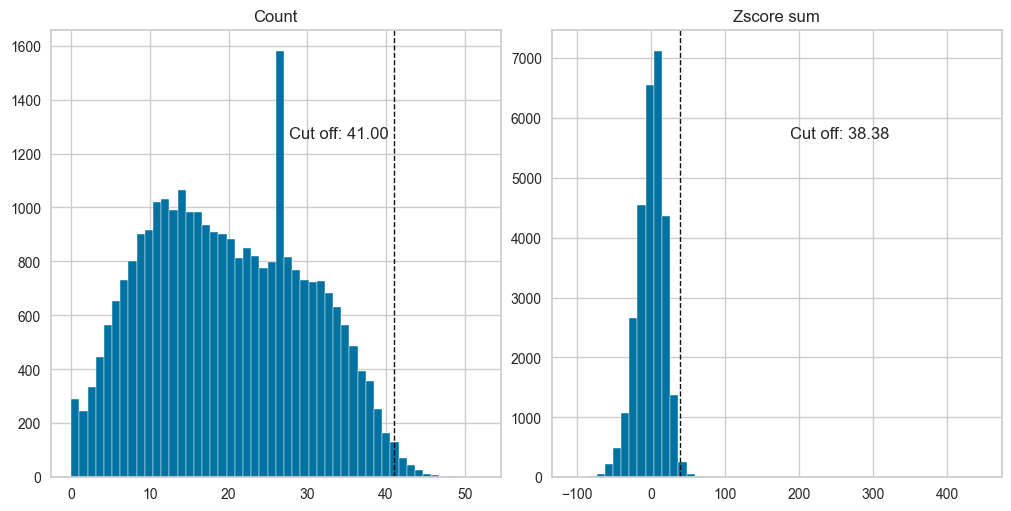

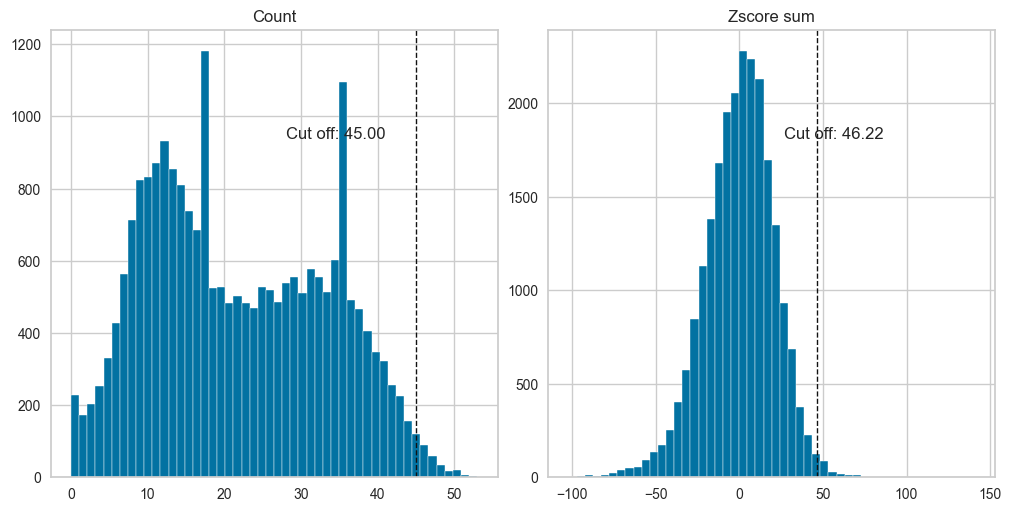

In [13]:
# This function helps to figure out what the cut-off should be for each region
for region in dfz.unique_region.unique():
    print(region)
    df_reg = dfz[dfz.unique_region == region]
    sp.pl.zcount_thres(dfz = df_reg, 
                col_num = col_num_last_marker, # last antibody index
                cut_off=0.01, #top 1% of cells
                count_bin=50)


In [14]:
# This is to remove top 1 % of all cells that are highly expressive for all antibodies
df_nn = pd.DataFrame()
cutoff_list = [[41, 38.38], [45, 46.22]]

for i in range(len(dfz.unique_region.unique())):
    df_reg = dfz[dfz.unique_region == dfz.unique_region.unique()[i]]
    df_reg_nn,cc = sp.pp.remove_noise(
        df=df_reg, 
        col_num=col_num_last_marker, # this is the column index that has the last protein feature
        z_count_thres=cutoff_list[i][0], # number obtained from the function above
        z_sum_thres=cutoff_list[i][1] # number obtained from the function above
    )
    print(df_reg_nn.shape)
    df_nn = pd.concat([df_nn,df_reg_nn], axis = 0)
df_nn.shape

1.4000000000000001% cells are removed.
(28436, 65)
1.7000000000000002% cells are removed.
(22702, 65)


(51138, 65)

In [15]:
#Save the df as a backup. We strongly recommend the Anndata format for further analysis!
df_nn.to_csv(output_dir + "df_nn_demo.csv")

In [16]:
# inspect which markers work, and drop the ones that did not work from the clustering step
# make an anndata to be compatible with the downstream clustering step
adata = sp.hf.make_anndata(
    df_nn = df_nn,
    col_sum = col_num_last_marker, # this is the column index that has the last protein feature # the rest will go into obs
    nonFuncAb_list = [] # Remove the antibodies that are not working from the clustering step
)
adata

AnnData object with n_obs × n_vars = 51138 × 58
    obs: 'DAPI', 'x', 'y', 'area', 'region_num', 'unique_region', 'condition'

In [17]:
# save the anndata object to a file
adata.write_h5ad(output_dir + 'adata_nn_demo.h5ad')

... storing 'region_num' as categorical
... storing 'unique_region' as categorical
... storing 'condition' as categorical


## Show the spatial distribution for size (Optional)

In [19]:
import pickle
with open(output_dir + 'overlay_tonsil1.pickle', 'rb') as f:
    overlay_data1 = pickle.load(f)

with open(output_dir + 'overlay_tonsil2.pickle', 'rb') as f:
    overlay_data2 = pickle.load(f)

In [30]:
df_nn.columns

Index(['FoxP3', 'HLA-DR', 'CD103', 'CHGA', 'EGFR', 'CD206', 'GFAP', 'PD-1',
       'BCL2', 'panCK', 'CD45RO', 'CD11b', 'CD56', 'CD163', 'CD21', 'CD8',
       'S100', 'Vimentin', 'PDGFRb', 'CCR7', 'CD57', 'CD34', 'Synaptophysin',
       'CD31', 'CXCR5', 'CD3', 'CD38', 'LAG3', 'CD25', 'CD16', 'IL-10', 'Ki67',
       'CLEC9A', 'p53', 'CD69', 'CD11c', 'CD68', 'Ox40', 'aSMA', 'CD20', 'CD4',
       'MUC-1', 'Podoplanin', 'CD45RA', 'CD15', 'betaCatenin', 'PAX5', 'MCT',
       'FAP', 'CD138', 'Tbet', 'GranzymeB', 'IDO-1', 'CD45', 'CollagenIV',
       'PD-L1', 'Arginase-1', 'GATA3', 'DAPI', 'x', 'y', 'area', 'region_num',
       'unique_region', 'condition'],
      dtype='object')

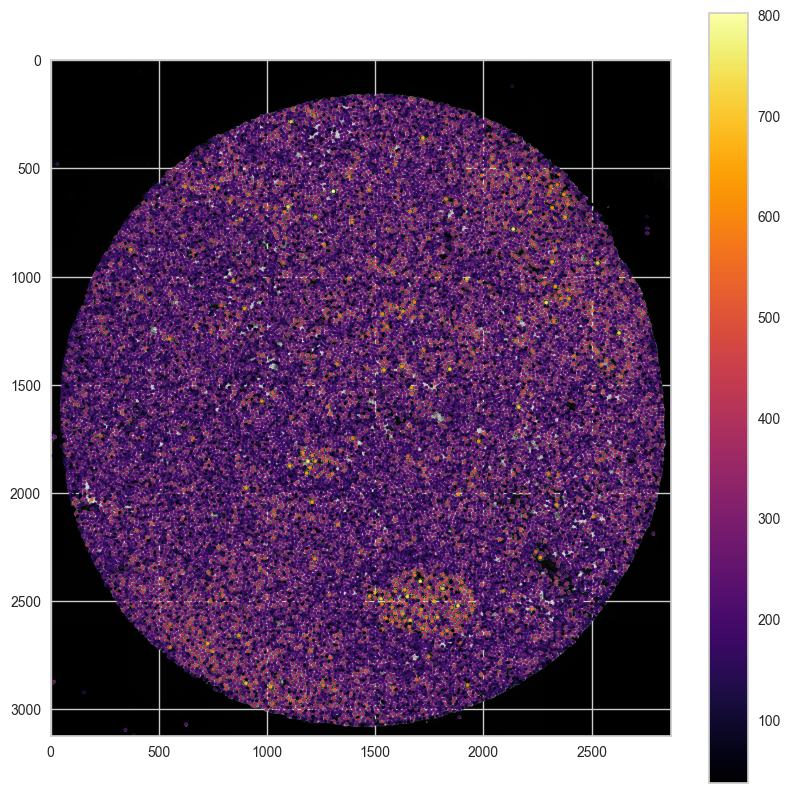

In [35]:
sp.pl.coordinates_on_image(
    df = df_nn.loc[df_nn['unique_region'] == 'reg001',:], 
    overlay_data = overlay_data1, color='area',  
    scale=False, # whether to scale to 1 or not
    dot_size=5,
    convert_to_grey=True, 
    fig_width=10, fig_height=10)

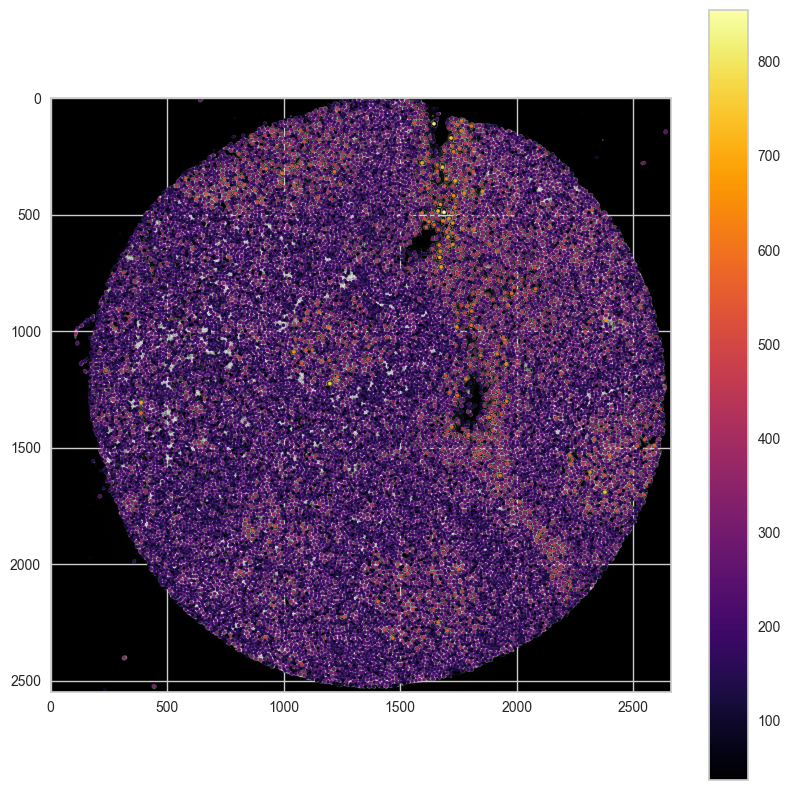

In [36]:
sp.pl.coordinates_on_image(
    df = df_nn.loc[df_nn['unique_region'] == 'reg002',:], 
    overlay_data = overlay_data2, 
    color='area', 
    scale=False, # whether to scale to 1 or not
    dot_size=5,
    convert_to_grey=True, 
    fig_width=10, fig_height=10 )

This function can also be used to inspect where certain markers are expressed in the tissue.

In [45]:
import matplotlib.pyplot as plt
plt.rc('axes', grid=False)  # remove gridlines

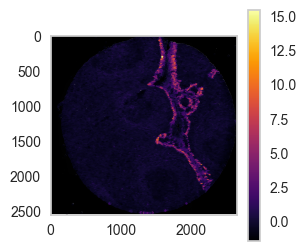

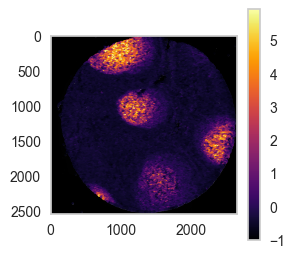

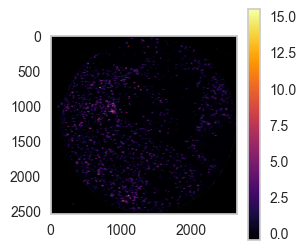

In [46]:
marker_list = ['EGFR', 'CD21', 'CD8']

for marker in marker_list:
    sp.pl.coordinates_on_image(
        df = df_nn.loc[df_nn['unique_region'] == 'reg002',:], 
        overlay_data = overlay_data2, 
        color=marker, 
        scale=False, # whether to scale to 1 or not
        dot_size=2,
        convert_to_grey=True, 
        fig_width=3, fig_height=3 )